# 00 Getting setup

In [1]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 00.1 Downloading the Data


In [2]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path

os.environ['KAGGLE_CONFIG_DIR'] = 'C:\\Users\\loq\\.kaggle'

api = KaggleApi()
api.authenticate()

data_path = Path("data/")
audio_path = data_path / "Data"

dataset = 'andradaolteanu/gtzan-dataset-music-genre-classification'

if audio_path.is_dir():
    print("Data already exists, skipping dawnload...")
else:    
    print("Downloading data...")
    api.dataset_download_files(dataset, path=data_path, unzip=True)

Data already exists, skipping dawnload...


### 00.2 Walking through the directory

In [3]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} audios in {dirpath}")

In [4]:
genres_original_path = audio_path / 'genres_original'

walk_through_dir(genres_original_path)

There are 10 directories and 0 audios in data\Data\genres_original
There are 0 directories and 100 audios in data\Data\genres_original\blues
There are 0 directories and 100 audios in data\Data\genres_original\classical
There are 0 directories and 100 audios in data\Data\genres_original\country
There are 0 directories and 100 audios in data\Data\genres_original\disco
There are 0 directories and 100 audios in data\Data\genres_original\hiphop
There are 0 directories and 99 audios in data\Data\genres_original\jazz
There are 0 directories and 100 audios in data\Data\genres_original\metal
There are 0 directories and 100 audios in data\Data\genres_original\pop
There are 0 directories and 100 audios in data\Data\genres_original\reggae
There are 0 directories and 100 audios in data\Data\genres_original\rock


# Getting data ready

### Creating spectogram on a single sample 

Shape y: (661794,)
Shape S: (128, 1293)
Shape S_db: (128, 1293)


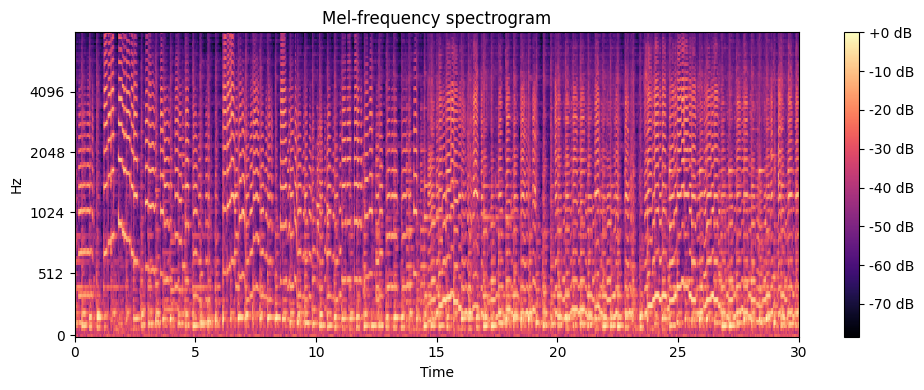

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

audio_path = 'data/Data/genres_original/jazz/jazz.00053.wav'

y, sr = librosa.load(audio_path, sr=22050)  # y — signal, sr — sample rate
print(f"Shape y: {y.shape}")

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
print(f"Shape S: {S.shape}")

S_dB = librosa.power_to_db(S, ref=np.max)
print(f"Shape S_db: {S_dB.shape}")

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [6]:
y.shape, S.shape, S_dB.shape

((661794,), (128, 1293), (128, 1293))

In [7]:
import torchaudio
from torchaudio import transforms
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [8]:
def find_classes(directory: Path):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError("Couldn't find any classes, please check file structure")
    class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [9]:
class_names, class_to_idx = find_classes(genres_original_path)

In [10]:
class AudioFolderCustom(Dataset):
    def __init__(self,
                 targ_dir: Path,
                 target_length: int,
                 transform=None,
                 percentage: Tuple[int, int]= (0.0, 1.0),
                 ):
        
        super().__init__()
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
        self.target_length = target_length
        all_paths = []
        targ_dir = Path(targ_dir)

        for cls_name in self.classes:
            cls_folder = targ_dir / cls_name
            wav_files = sorted(cls_folder.glob('*.wav'))
            start_files = int(len(wav_files) * percentage[0])
            end_files = int(len(wav_files) * percentage[1])
            selected_files = wav_files[start_files:end_files]
            all_paths.extend(selected_files)

        self.paths = all_paths
        

    def __len__(self):
        return len(self.paths) 

    def __getitem__(self, idx):
        filepath= self.paths[idx]
        class_name = filepath.parent.name
        class_idx = self.class_to_idx[class_name]
        waveform, sample_rate = torchaudio.load(filepath)
        if self.transform:
            waveform = self.transform(waveform)
        #     waveform = librosa.feature.melspectrogram(y=waveform, 
        #                                               sr=sample_rate, 
        #                                               n_fft=2048,
        #                                               hop_length=512, 
        #                                               n_mels=128, 
        #                                               fmax=8000)
            
        #     waveform = librosa.power_to_db(waveform, ref=np.max)

        # waveform = torch.from_numpy(waveform).type(torch.float32).unsqueeze(dim=0)
        current_length = waveform.shape[2]
        if current_length > self.target_length:
            waveform = waveform[:, :, :self.target_length]
        elif current_length < self.target_length:
            pad_len = self.target_length - current_length
            waveform = torch.nn.functional.pad(waveform, (0, pad_len))


        return waveform, class_idx  

In [11]:
class NormalizeDBRange(torch.nn.Module):
    def __init__(self, min_db: float = -60.0, max_db: float = 40.0):
        super().__init__()
        self.min_db = min_db
        self.max_db = max_db

    def forward(self, x):
        x = torch.clamp(x, min=self.min_db, max=self.max_db)
        x = (x - self.min_db) / (self.max_db - self.min_db)
        return x

22050
torch.Size([1, 128, 1293])


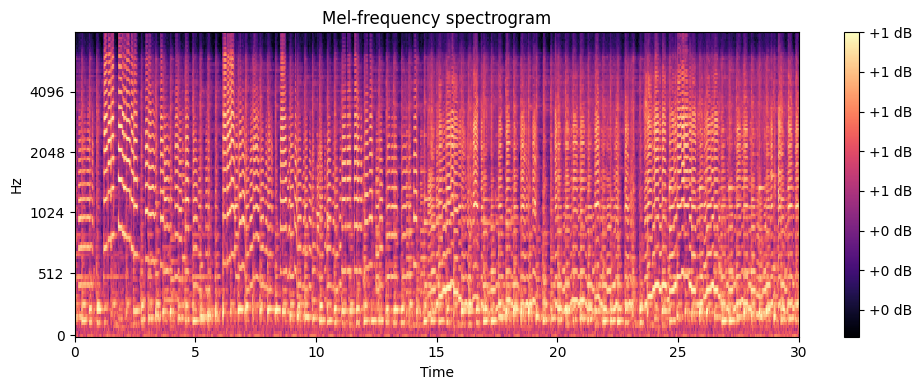

In [12]:

train_transform = nn.Sequential(
    transforms.MelSpectrogram(
        sample_rate=22050,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ),
    transforms.AmplitudeToDB(),
    NormalizeDBRange(-60, 40)
)

test_transform = nn.Sequential(
    transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=2048,
    hop_length=512,
    n_mels=128
    ),
    transforms.AmplitudeToDB(),
    NormalizeDBRange(-60, 40)
)

waveform, sample_rate = torchaudio.load(audio_path)
print(sample_rate)
transformed_audio = train_transform(waveform)
print(transformed_audio.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(transformed_audio.squeeze().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


In [13]:
target_length = 1000

train_data_custom = AudioFolderCustom(targ_dir=genres_original_path,
                                      target_length=target_length,
                                      transform=train_transform,
                                      percentage=(0.0, 0.4))

test_data_custom = AudioFolderCustom(targ_dir=genres_original_path,
                                     target_length=target_length,
                                     transform=test_transform,
                                     percentage=(0.4, 0.5))
train_data_custom, test_data_custom, len(train_data_custom), len(test_data_custom)

(<__main__.AudioFolderCustom at 0x22c9c3e83b0>,
 399,
 100)

In [14]:
train_data_custom.class_to_idx

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [15]:
train_data_custom[0][0]

tensor([[[0.7348, 0.6596, 0.6186,  ..., 0.6015, 0.5739, 0.6303],
         [0.7925, 0.7648, 0.7243,  ..., 0.7194, 0.7113, 0.7664],
         [0.7731, 0.7887, 0.7918,  ..., 0.8473, 0.8428, 0.8513],
         ...,
         [0.3223, 0.2631, 0.1320,  ..., 0.1722, 0.1609, 0.1937],
         [0.3228, 0.2628, 0.0388,  ..., 0.0594, 0.0603, 0.1223],
         [0.3225, 0.2624, 0.0017,  ..., 0.0098, 0.0032, 0.0312]]])

In [16]:
train_data_custom[0][0].max(), train_data_custom[0][0].min()

(tensor(1.), tensor(0.))

In [17]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 0

torch.manual_seed(19)
train_dataloader = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data_custom,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, len(train_dataloader), len(test_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x22c9c30da60>,
 13,
 4)

In [18]:
audio, label = next(iter(test_dataloader))
audio.shape, label.shape

(torch.Size([32, 1, 128, 1000]), torch.Size([32]))

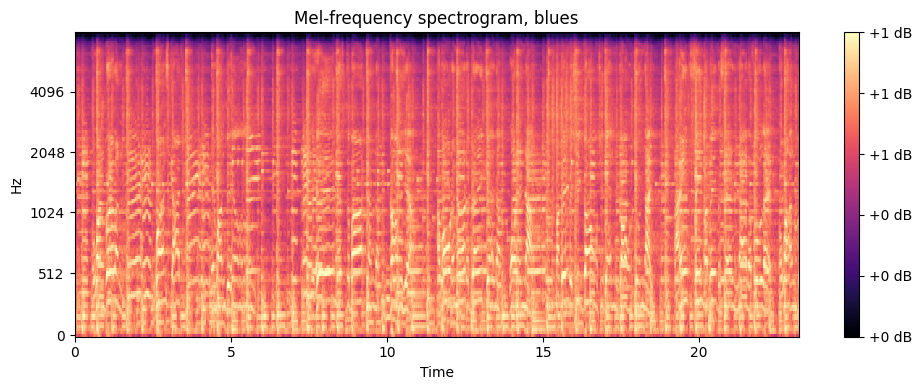

In [19]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(train_data_custom[0][0].squeeze().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram, {class_names[train_data_custom[0][1]]}')
plt.tight_layout()
plt.show()

In [33]:
import importlib
import models.cnn_genre as cnn

importlib.reload(cnn)
# class AudioCNN_0(nn.Module):
#     def __init__(self, input_shape, hidden_units, output_shape):
#         super().__init__()
#         self.conv2d_block1 = nn.Sequential(
#             nn.Conv2d(in_channels=input_shape,
#                       out_channels=hidden_units,
#                       kernel_size=2,
#                       stride=1,
#                       padding=1),
#             nn.BatchNorm2d(hidden_units),          
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=4)          
#         )

#         self.conv2d_block2 = nn.Sequential(
#             nn.Conv2d(in_channels=hidden_units,
#                       out_channels=hidden_units * 2,
#                       kernel_size=2,
#                       stride=1,
#                       padding=1),
#             nn.BatchNorm2d(hidden_units * 2),          
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=4)
#         )

#         self.conv2d_block3 = nn.Sequential(
#             nn.Conv2d(in_channels=hidden_units * 2,
#                       out_channels=hidden_units * 4,
#                       kernel_size=2,
#                       stride=1,
#                       padding=1),
#             nn.BatchNorm2d(hidden_units * 4),          
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=4)
#         )

#         self.classifier = nn.Sequential(

#             nn.Flatten(),
#             nn.Linear(in_features=hidden_units * 4 * 2 * 15,
#                       out_features=128),
#             nn.ReLU(),
#             nn.Linear(in_features=128,
#                       out_features=output_shape)                    
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # x = self.conv2d_block1(x)
#         # print(x.shape)
#         # x = self.conv2d_block2(x)
#         # print(x.shape)
#         # x = self.conv2d_block3(x)
#         # print(x.shape)
#         # x = self.classifier(x)
#         # print(x.shape)
#         # return x
#         return self.classifier(self.conv2d_block3(self.conv2d_block2(self.conv2d_block1(x))))
    



<module 'models.cnn_genre' from 'c:\\Users\\loq\\Documents\\Deep Learning\\Audio-Classification-GTZAN\\models\\cnn_genre.py'>

In [34]:
torch.manual_seed(19)
model_0 = cnn.AudioCNN_0(input_shape=1, 
                     hidden_units=16, 
                     output_shape=10).to(device)

model_0

AudioCNN_0(
  (conv2d_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2d_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

In [35]:
train_data_custom[0][0].shape

torch.Size([1, 128, 1000])

In [36]:
model_0.eval()
with torch.inference_mode():

    y_pred = model_0(train_data_custom[0][0].unsqueeze(dim=0).to(device))
    print(y_pred)
    print(torch.softmax(y_pred, dim=1))
    label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    print(class_names[label])
    label = torch.argmax(y_pred, dim=1)
    print(class_names[label])

tensor([[-0.0925,  0.0727, -0.0683, -0.0517,  0.0359,  0.0423,  0.0015, -0.0641,
         -0.0568,  0.0645]], device='cuda:0')
tensor([[0.0921, 0.1086, 0.0943, 0.0959, 0.1047, 0.1054, 0.1011, 0.0947, 0.0954,
         0.1077]], device='cuda:0')
classical
classical


In [37]:

import torchinfo
from torchinfo import summary

summary(model_0, input_size=[1,1,128,1000])

Layer (type:depth-idx)                   Output Shape              Param #
AudioCNN_0                               [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 250]          --
│    └─Conv2d: 2-1                       [1, 16, 129, 1001]        80
│    └─BatchNorm2d: 2-2                  [1, 16, 129, 1001]        32
│    └─ReLU: 2-3                         [1, 16, 129, 1001]        --
│    └─MaxPool2d: 2-4                    [1, 16, 32, 250]          --
├─Sequential: 1-2                        [1, 32, 8, 62]            --
│    └─Conv2d: 2-5                       [1, 32, 33, 251]          2,080
│    └─BatchNorm2d: 2-6                  [1, 32, 33, 251]          64
│    └─ReLU: 2-7                         [1, 32, 33, 251]          --
│    └─MaxPool2d: 2-8                    [1, 32, 8, 62]            --
├─Sequential: 1-3                        [1, 64, 2, 15]            --
│    └─Conv2d: 2-9                       [1, 64, 9, 63]            8,256
│    └─Ba

In [38]:
from torch.utils.data import dataloader

def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() # maybe should add .item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)    
    train_acc /= len(dataloader)
    return train_loss, train_acc
    

In [39]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = torch.argmax(test_pred_logits, dim=1)
            test_acc += (test_pred_labels==y).sum().item() / len(test_pred_logits)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc 

In [40]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,          
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        print(f"Epoch: {epoch} | Train loss {train_loss:.4f}, Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=10,
      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss 2.4418, Train acc: 0.2008 | Test loss: 2.2188, Test acc: 0.2969
Epoch: 1 | Train loss 1.6919, Train acc: 0.3457 | Test loss: 2.1666, Test acc: 0.1953
Epoch: 2 | Train loss 1.4009, Train acc: 0.4563 | Test loss: 2.1544, Test acc: 0.2266
Epoch: 3 | Train loss 1.1413, Train acc: 0.5925 | Test loss: 2.1543, Test acc: 0.3281
Epoch: 4 | Train loss 1.0796, Train acc: 0.5516 | Test loss: 2.2778, Test acc: 0.3281
Epoch: 5 | Train loss 0.9550, Train acc: 0.6447 | Test loss: 2.3249, Test acc: 0.3125
Epoch: 6 | Train loss 0.8798, Train acc: 0.6426 | Test loss: 2.1182, Test acc: 0.2500
Epoch: 7 | Train loss 0.7704, Train acc: 0.7175 | Test loss: 2.4790, Test acc: 0.2891
Epoch: 8 | Train loss 0.7523, Train acc: 0.7288 | Test loss: 2.0663, Test acc: 0.2812
Epoch: 9 | Train loss 0.7450, Train acc: 0.7415 | Test loss: 3.0022, Test acc: 0.1875


In [42]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_acc = results["test_acc"]

    epochs = range(len(results["train_loss"]))
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_acc, label='test_accuracy')
    plt.title('Accuracy')
    plt.ylabel("Accuracy")
    plt.xlabel('Epochs')
    plt.legend()

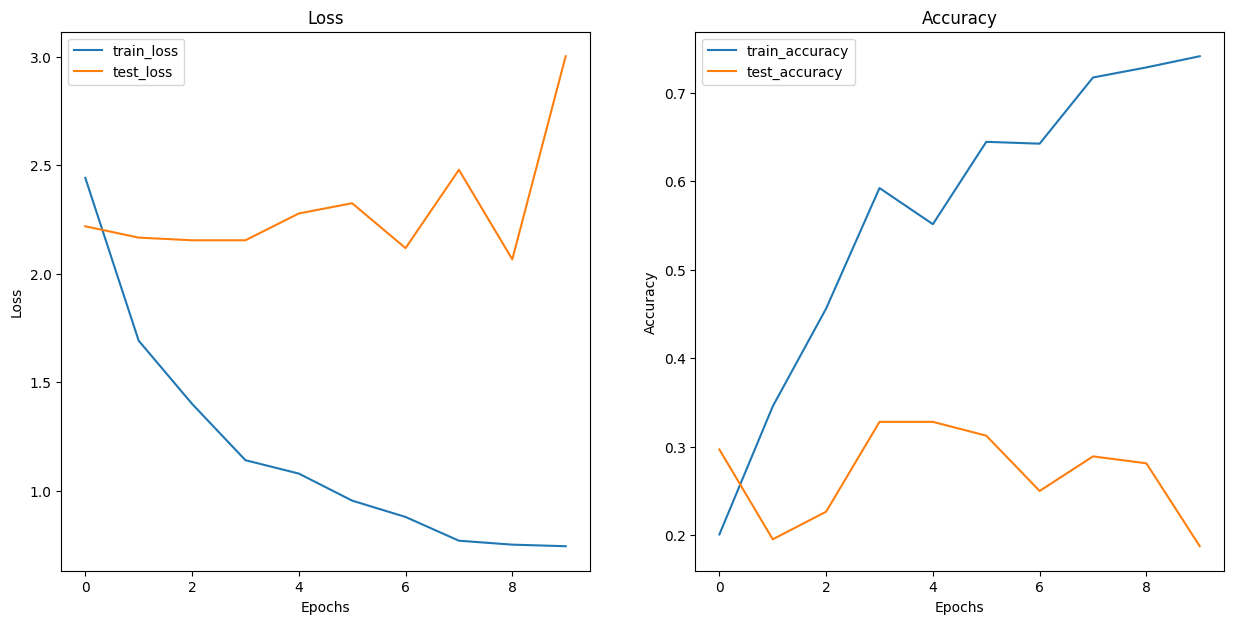

In [43]:
plot_loss_curves(model_0_results)

In [44]:
import random
def make_predictions(model: nn.Module,
                     data: AudioFolderCustom,
                     n: int = 10,
                     device=device):                   

        count_correct = 0
        rand_idxs = random.sample(range(len(data)), k=n)
        model.eval()
        with torch.inference_mode():
                for idx in rand_idxs:
                        y_pred = model(data[idx][0].unsqueeze(dim=0).to(device))
                        pred_label = torch.argmax(y_pred, dim=1)
                        print(f"Prediction genre: {class_names[pred_label]} | True genre: {class_names[data[idx][1]]}")
                        count_correct += pred_label==data[idx][1]
        print("-----------") 
        print(f"Correct preditions: {count_correct.item()} out of {n}\n-----------")                   


In [45]:
make_predictions(model=model_0,
                 data=test_data_custom,
                 n=10)

make_predictions(model=model_0,
                 data=train_data_custom,
                 n=10)


Prediction genre: rock | True genre: blues
Prediction genre: rock | True genre: blues
Prediction genre: pop | True genre: pop
Prediction genre: rock | True genre: blues
Prediction genre: country | True genre: country
Prediction genre: country | True genre: country
Prediction genre: country | True genre: rock
Prediction genre: pop | True genre: hiphop
Prediction genre: classical | True genre: disco
Prediction genre: disco | True genre: pop
-----------
Correct preditions: 3 out of 10
-----------
Prediction genre: rock | True genre: rock
Prediction genre: blues | True genre: reggae
Prediction genre: country | True genre: country
Prediction genre: classical | True genre: classical
Prediction genre: country | True genre: pop
Prediction genre: hiphop | True genre: hiphop
Prediction genre: rock | True genre: rock
Prediction genre: country | True genre: disco
Prediction genre: blues | True genre: blues
Prediction genre: rock | True genre: hiphop
-----------
Correct preditions: 6 out of 10
----

In [46]:
importlib.reload(cnn)

torch.manual_seed(19)
model_1 = cnn.AudioCNN_1(input_shape=1,
                     hidden_units=16,
                     output_shape=len(class_names)).to(device)

summary(model_1, input_size=[1,1,128,1000])


Layer (type:depth-idx)                   Output Shape              Param #
AudioCNN_1                               [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 250]          --
│    └─Conv2d: 2-1                       [1, 16, 129, 1001]        80
│    └─BatchNorm2d: 2-2                  [1, 16, 129, 1001]        32
│    └─ReLU: 2-3                         [1, 16, 129, 1001]        --
│    └─MaxPool2d: 2-4                    [1, 16, 32, 250]          --
├─Sequential: 1-2                        [1, 32, 8, 62]            --
│    └─Conv2d: 2-5                       [1, 32, 33, 251]          2,080
│    └─BatchNorm2d: 2-6                  [1, 32, 33, 251]          64
│    └─ReLU: 2-7                         [1, 32, 33, 251]          --
│    └─MaxPool2d: 2-8                    [1, 32, 8, 62]            --
├─Sequential: 1-3                        [1, 64, 2, 15]            --
│    └─Conv2d: 2-9                       [1, 64, 9, 63]            8,256
│    └─Ba

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20,
                        device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss 2.3370, Train acc: 0.2732 | Test loss: 2.2490, Test acc: 0.3672
Epoch: 1 | Train loss 1.5666, Train acc: 0.4434 | Test loss: 2.3531, Test acc: 0.1797
Epoch: 2 | Train loss 1.1117, Train acc: 0.5856 | Test loss: 2.2686, Test acc: 0.2266
Epoch: 3 | Train loss 0.9196, Train acc: 0.6550 | Test loss: 2.1830, Test acc: 0.3516
Epoch: 4 | Train loss 0.7448, Train acc: 0.7587 | Test loss: 1.9269, Test acc: 0.3594
Epoch: 5 | Train loss 0.5977, Train acc: 0.8173 | Test loss: 2.3612, Test acc: 0.2188
Epoch: 6 | Train loss 0.6527, Train acc: 0.7508 | Test loss: 2.6288, Test acc: 0.3281
Epoch: 7 | Train loss 0.6094, Train acc: 0.7944 | Test loss: 2.3193, Test acc: 0.3516
Epoch: 8 | Train loss 0.4460, Train acc: 0.8726 | Test loss: 2.3374, Test acc: 0.2812
Epoch: 9 | Train loss 0.4116, Train acc: 0.8596 | Test loss: 1.9957, Test acc: 0.4062
Epoch: 10 | Train loss 0.3751, Train acc: 0.8840 | Test loss: 1.9406, Test acc: 0.4141
Epoch: 11 | Train loss 0.3395, Train acc: 0.8912 | Te

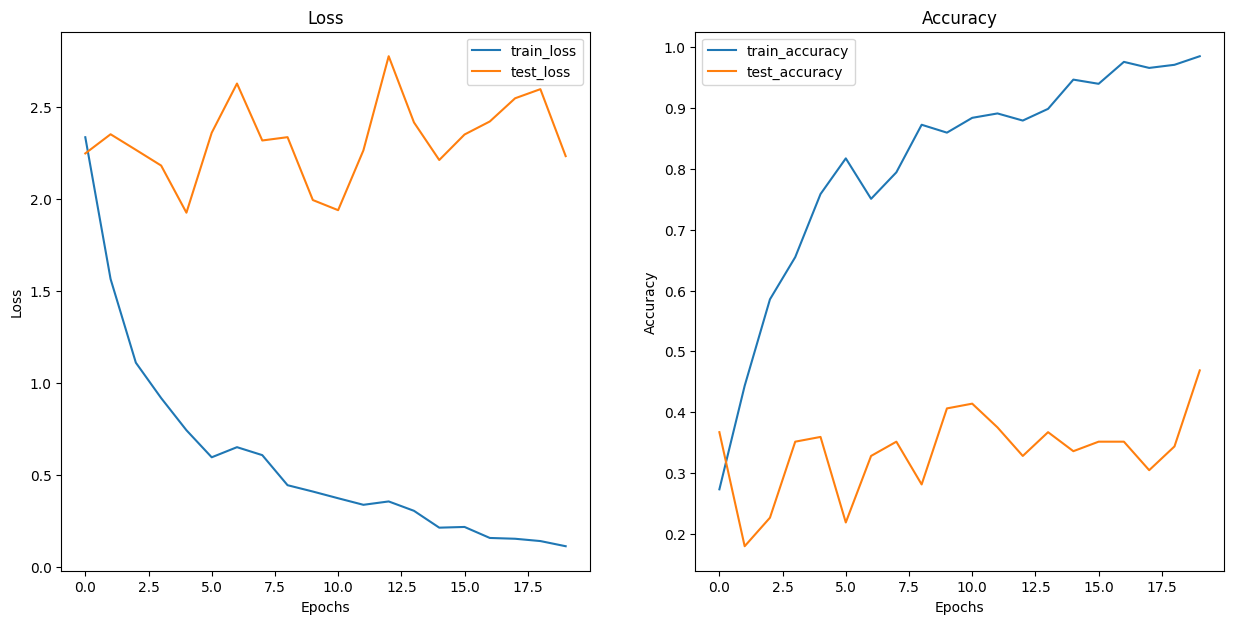

In [48]:
plot_loss_curves(model_1_results)

In [92]:
train_transform_with_augmentation = nn.Sequential(
    transforms.MelSpectrogram(
        sample_rate=22050,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ),
    transforms.AmplitudeToDB(),
    NormalizeDBRange(-60, 40),
    transforms.FrequencyMasking(freq_mask_param=15),
    transforms.TimeMasking(time_mask_param=50),
    #transforms.Vol(gain=0.8, gain_type='amplitude')
)

test_transform = nn.Sequential(
    transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=2048,
    hop_length=512,
    n_mels=128
    ),
    transforms.AmplitudeToDB(),
    NormalizeDBRange(-60, 40)
)

train_data_augmented = AudioFolderCustom(targ_dir=genres_original_path,
                                                       target_length=1000,
                                                       transform=train_transform_with_augmentation,
                                                       percentage=(0, 0.8))

test_data = AudioFolderCustom(targ_dir=genres_original_path,
                                    target_length=1000,
                                    transform=test_transform,
                                    percentage=(0.8, 1.0))

print(train_data_augmented[0][0])

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)


train_dataloader_augmented, test_dataloader

tensor([[[0.7348, 0.6596, 0.6186,  ..., 0.6015, 0.5739, 0.6303],
         [0.7925, 0.7648, 0.7243,  ..., 0.7194, 0.7113, 0.7664],
         [0.7731, 0.7887, 0.7918,  ..., 0.8473, 0.8428, 0.8513],
         ...,
         [0.3223, 0.2631, 0.1320,  ..., 0.1722, 0.1609, 0.1937],
         [0.3228, 0.2628, 0.0388,  ..., 0.0594, 0.0603, 0.1223],
         [0.3225, 0.2624, 0.0017,  ..., 0.0098, 0.0032, 0.0312]]])


(<torch.utils.data.dataloader.DataLoader at 0x22d4dc4bfb0>,
 <torch.utils.data.dataloader.DataLoader at 0x22d4dc49b50>)

In [93]:
len(train_data_augmented), len(test_data), len(train_dataloader_augmented), len(test_dataloader)

(799, 200, 25, 7)

In [94]:
next(iter(train_dataloader_augmented))

[tensor([[[[0.6859, 0.6816, 0.6659,  ..., 0.6904, 0.7025, 0.6917],
           [0.7397, 0.6906, 0.5795,  ..., 0.7711, 0.7710, 0.7579],
           [0.7425, 0.6845, 0.5822,  ..., 0.8729, 0.8786, 0.8643],
           ...,
           [0.4107, 0.3506, 0.0528,  ..., 0.0172, 0.0048, 0.0149],
           [0.4081, 0.3479, 0.0202,  ..., 0.0134, 0.0028, 0.0213],
           [0.4081, 0.3480, 0.0200,  ..., 0.0155, 0.0069, 0.0145]]],
 
 
         [[[0.8211, 0.7617, 0.3566,  ..., 0.4772, 0.4542, 0.4613],
           [0.8397, 0.7769, 0.6052,  ..., 0.6745, 0.6853, 0.6766],
           [0.8565, 0.8009, 0.6714,  ..., 0.8143, 0.8322, 0.8237],
           ...,
           [0.6651, 0.6411, 0.6125,  ..., 0.7796, 0.7611, 0.7447],
           [0.6496, 0.6314, 0.6210,  ..., 0.7729, 0.7445, 0.7150],
           [0.6745, 0.6475, 0.6413,  ..., 0.7723, 0.7529, 0.7275]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.8178, 0.8096, 0.7583],
           [0.0000, 0.0000, 0.0000,  ..., 0.9109, 0.8709, 0.8912],
           [0.0000

In [96]:
importlib.reload(cnn)
torch.manual_seed(19)
model_1_1 = cnn.AudioCNN_1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1_1.parameters(), lr=0.001)

model_1_1_results = train(model=model_1_1,
                          train_dataloader=train_dataloader_augmented,
                          test_dataloader=test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=10,
                          device=device)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss 2.4290, Train acc: 0.1741 | Test loss: 2.4451, Test acc: 0.1830
Epoch: 1 | Train loss 1.7717, Train acc: 0.3705 | Test loss: 2.3361, Test acc: 0.2054
Epoch: 2 | Train loss 1.5044, Train acc: 0.4520 | Test loss: 1.6166, Test acc: 0.3661
Epoch: 3 | Train loss 1.2850, Train acc: 0.5269 | Test loss: 1.7641, Test acc: 0.3259
Epoch: 4 | Train loss 1.1915, Train acc: 0.5771 | Test loss: 1.6041, Test acc: 0.4330
Epoch: 5 | Train loss 1.0431, Train acc: 0.6471 | Test loss: 1.5648, Test acc: 0.3839
Epoch: 6 | Train loss 1.0011, Train acc: 0.6545 | Test loss: 2.1002, Test acc: 0.3795
Epoch: 7 | Train loss 0.9150, Train acc: 0.6896 | Test loss: 1.9197, Test acc: 0.4821
Epoch: 8 | Train loss 0.8237, Train acc: 0.7271 | Test loss: 3.0685, Test acc: 0.3036
Epoch: 9 | Train loss 0.7958, Train acc: 0.7272 | Test loss: 2.5265, Test acc: 0.3438


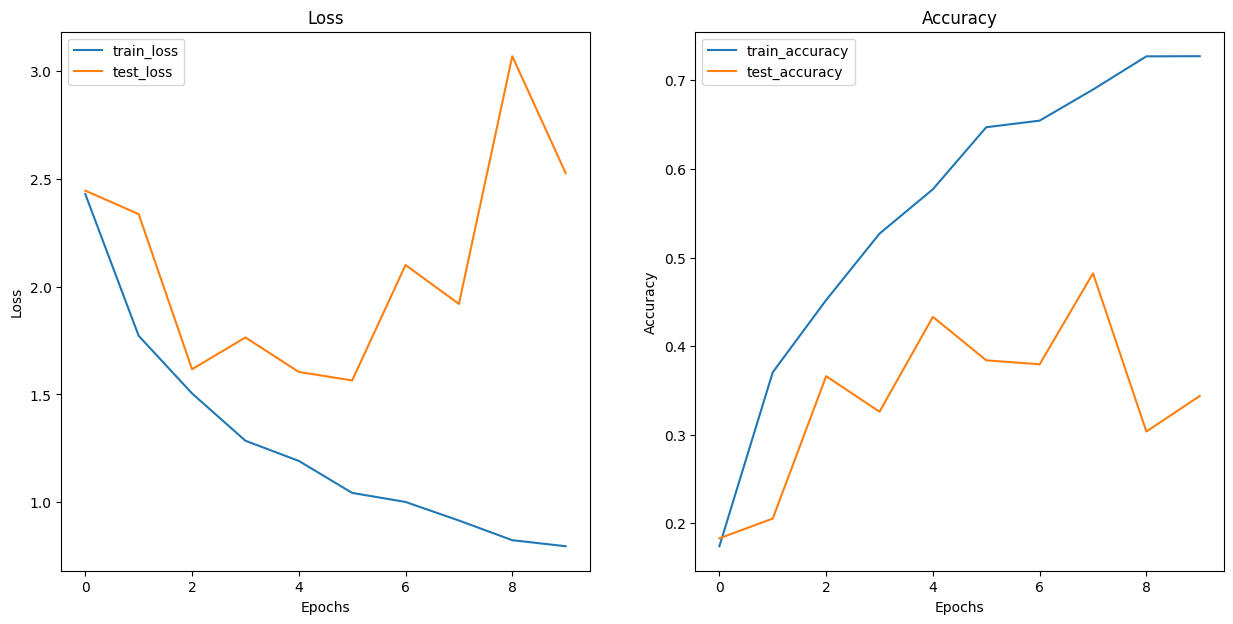

In [97]:
plot_loss_curves(model_1_1_results)

In [98]:
make_predictions(model_1_1,test_data)

Prediction genre: blues | True genre: disco
Prediction genre: blues | True genre: hiphop
Prediction genre: country | True genre: rock
Prediction genre: country | True genre: blues
Prediction genre: country | True genre: reggae
Prediction genre: reggae | True genre: reggae
Prediction genre: blues | True genre: blues
Prediction genre: pop | True genre: pop
Prediction genre: rock | True genre: rock
Prediction genre: country | True genre: rock
-----------
Correct preditions: 4 out of 10
-----------


In [195]:
importlib.reload(cnn)
torch.manual_seed(19)
model_2 = cnn.AudioCNN_2(hidden_units=8).to(device)

summary(model_2, input_size=[1,1,128,1000])

Layer (type:depth-idx)                   Output Shape              Param #
AudioCNN_2                               [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 43, 333]           --
│    └─Conv2d: 2-1                       [1, 8, 129, 1001]         40
│    └─BatchNorm2d: 2-2                  [1, 8, 129, 1001]         16
│    └─ReLU: 2-3                         [1, 8, 129, 1001]         --
│    └─MaxPool2d: 2-4                    [1, 8, 43, 333]           --
├─Sequential: 1-2                        [1, 16, 14, 111]          --
│    └─Conv2d: 2-5                       [1, 16, 44, 334]          528
│    └─BatchNorm2d: 2-6                  [1, 16, 44, 334]          32
│    └─ReLU: 2-7                         [1, 16, 44, 334]          --
│    └─MaxPool2d: 2-8                    [1, 16, 14, 111]          --
├─Sequential: 1-3                        [1, 32, 5, 37]            --
│    └─Conv2d: 2-9                       [1, 32, 15, 112]          2,080
│    └─Batc

In [196]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

model_2_results = train(model=model_2,
      train_dataloader=train_dataloader_augmented,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=25)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train loss 2.3163, Train acc: 0.1965 | Test loss: 2.4481, Test acc: 0.1295
Epoch: 1 | Train loss 1.9957, Train acc: 0.2931 | Test loss: 2.0618, Test acc: 0.2054
Epoch: 2 | Train loss 1.7604, Train acc: 0.3616 | Test loss: 1.9027, Test acc: 0.2232
Epoch: 3 | Train loss 1.4067, Train acc: 0.5057 | Test loss: 1.7880, Test acc: 0.3438
Epoch: 4 | Train loss 1.2610, Train acc: 0.5431 | Test loss: 1.5498, Test acc: 0.4688
Epoch: 5 | Train loss 1.0454, Train acc: 0.6522 | Test loss: 1.9127, Test acc: 0.3393
Epoch: 6 | Train loss 0.9497, Train acc: 0.6859 | Test loss: 1.5565, Test acc: 0.4777
Epoch: 7 | Train loss 0.9129, Train acc: 0.6646 | Test loss: 1.5499, Test acc: 0.4821
Epoch: 8 | Train loss 0.7811, Train acc: 0.7371 | Test loss: 1.3058, Test acc: 0.5179
Epoch: 9 | Train loss 0.7298, Train acc: 0.7560 | Test loss: 1.2592, Test acc: 0.5446
Epoch: 10 | Train loss 0.7222, Train acc: 0.7510 | Test loss: 1.5822, Test acc: 0.4732
Epoch: 11 | Train loss 0.6406, Train acc: 0.7634 | Te

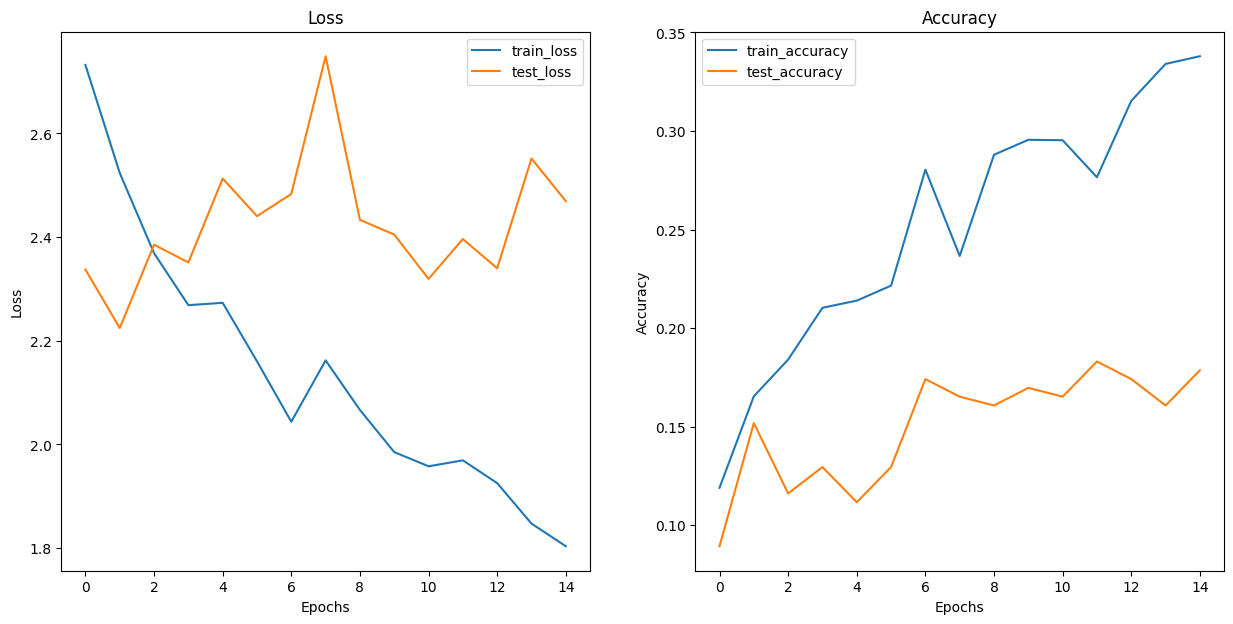

In [ ]:
plot_loss_curves(model_2_results)

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

def plot_confmat(model: nn.Module,
                 test_data: AudioFolderCustom,
                 device=device):
    y_preds = []
    y_targets = []

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_data):
            X = X.unsqueeze(dim=0).to(device)
            y_logits_tensor = model(X)
            y_pred = torch.argmax(y_logits_tensor, dim=1)
            y_preds.append(y_pred.cpu())
            y_targets.append(torch.tensor([y]))
        
    y_pred_tensor = torch.cat(y_preds)
    y_targets_tensor = torch.cat(y_targets)
    
    confmat = ConfusionMatrix(num_classes=len(test_data.classes), task='multiclass')
    confmat_tensor = confmat(preds=y_pred_tensor, target=y_targets_tensor)

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(10,7)
    )

  0%|          | 0/200 [00:00<?, ?it/s]

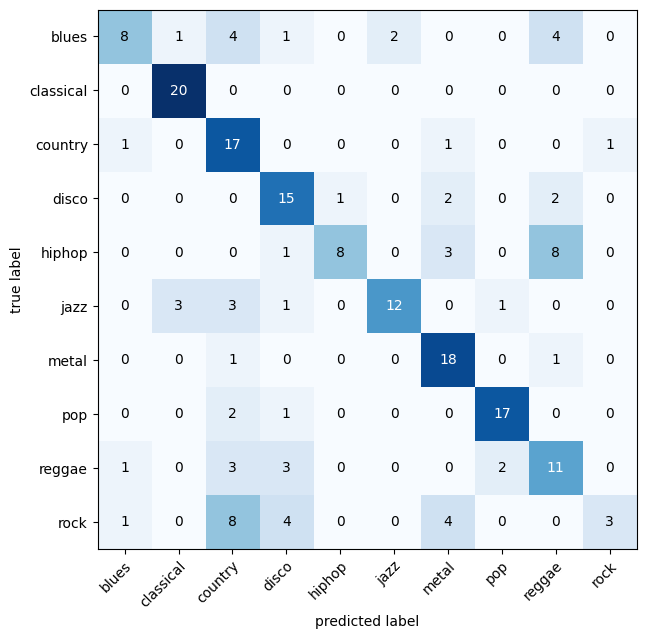

In [197]:
plot_confmat(model=model_2,
             test_data=test_data)

In [ ]:
importlib.reload(cnn)
torch.manual_seed(19)
model_3 = cnn.AudioCNN_3(hidden_units=8).to(device)
model_3(test_data[0][0].unsqueeze(dim=0).to(device))
summary(model_3, input_size=[1,1,128,1000])


Layer (type:depth-idx)                   Output Shape              Param #
AudioCNN_3                               [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 63, 499]           --
│    └─Conv2d: 2-1                       [1, 8, 126, 998]          80
│    └─BatchNorm2d: 2-2                  [1, 8, 126, 998]          16
│    └─ReLU: 2-3                         [1, 8, 126, 998]          --
│    └─MaxPool2d: 2-4                    [1, 8, 63, 499]           --
│    └─Dropout: 2-5                      [1, 8, 63, 499]           --
├─Sequential: 1-2                        [1, 16, 30, 248]          --
│    └─Conv2d: 2-6                       [1, 16, 61, 497]          1,168
│    └─BatchNorm2d: 2-7                  [1, 16, 61, 497]          32
│    └─ReLU: 2-8                         [1, 16, 61, 497]          --
│    └─MaxPool2d: 2-9                    [1, 16, 30, 248]          --
│    └─Dropout: 2-10                     [1, 16, 30, 248]          --
├─Sequential

  0%|          | 0/200 [00:00<?, ?it/s]

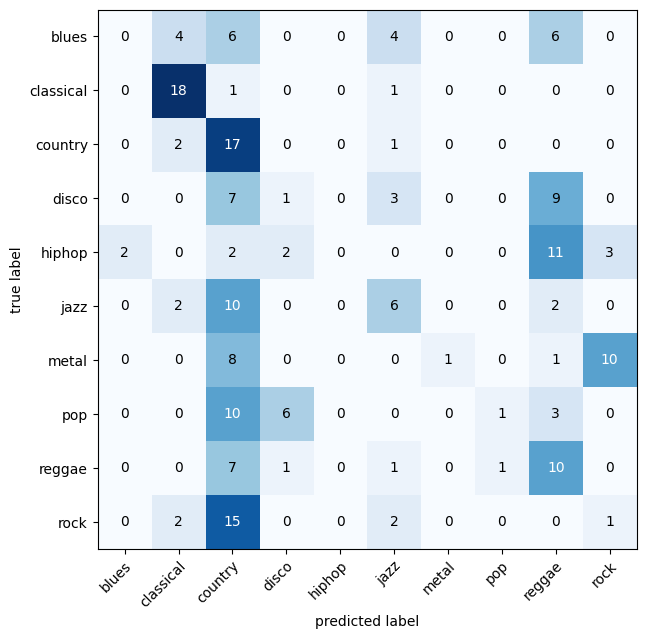

In [ ]:
plot_confmat(model_3, test_data)